In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2


In [2]:
import time
import datetime
from tsai.basics import *
import sktime
import sklearn

from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *

from scipy.io import loadmat
from data_utils import get_data
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from utils import cluster_acc

# Data

In [5]:

train_data = loadmat('earthb.mat')
all_data = train_data['images']
all_target = train_data['labels']

# load data
x_train, x_valid, x_test, y_train, y_valid, y_test, splits, splits_test = get_data(all_data, all_target, dataset='eq', seed=1, norm=1)
print(x_train.shape, x_valid.shape, x_test.shape)
# set contains training and validation
X = np.concatenate([x_train, x_valid])
y = np.concatenate([y_train, y_valid])



2022-07-15 20:30:29.845 | INFO     | data_utils:normalization:12 - Normalization in range [-0.4522, 0.4593]


(13883, 3, 2000) (1543, 3, 2000) (6612, 3, 2000)


# Cluster Accuracy, Recall, F1-score

In [6]:
from scipy.optimize import linear_sum_assignment as hungarian
def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = hungarian(w.max() - w)
    print(row_ind, col_ind)
    print(w)
    from sklearn.metrics import precision_recall_fscore_support
    pred = np.copy(y_pred)
    for i in range(len(row_ind)):
        idx = np.where(y_pred == row_ind[i])
        pred[idx] = col_ind[i]
    print('precision recall  F1 score in micro:', precision_recall_fscore_support(y_true, pred, average='micro'))
    print('precision recall  F1 score in macro:', precision_recall_fscore_support(y_true, pred, average='macro'))
    print('precision recall  F1 score in weighted:', precision_recall_fscore_support(y_true, pred, average='weighted'))
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size, pred

# MiniRocket feature extract

In [7]:

start = time.time()
mrf = MiniRocketFeatures(x_train.shape[1], x_train.shape[2]).to(default_device())
mrf.fit(x_train)

X_feat = get_minirocket_features(X, mrf, chunksize=512, to_np=True).reshape(X.shape[0], -1)

print("feature extract time", time.time() - start)


feature extract time 28.131389617919922


In [8]:
X_feat.shape

(15426, 9996)

# KMeans from MiniRocket

In [9]:
start = time.time()

model = KMeans(n_clusters=3)
y_pred = model.fit_predict(X_feat)


print("Kmeans training time", time.time() - start)

Kmeans training time 34.1346640586853


In [10]:
start = time.time()

X_test_feat = get_minirocket_features(x_test, mrf, chunksize=512, to_np=True).reshape(x_test.shape[0], -1)
y_pred = model.predict(X_test_feat)
print('test accuracy')
train_valid_acc, aligned_pred = cluster_acc(y_test, y_pred)
end = time.time()
print("Datashape, train, valid, test: ", x_train.shape, x_valid.shape, x_test.shape)
print("total time(evaluate cluster accuracy) takes %d seconds, " % (end - start), str(datetime.timedelta(seconds=end-start)))

test accuracy
[0 1 2] [2 1 0]
[[ 168    5 2064]
 [1470 1428    0]
 [1329  148    0]]
precision recall  F1 score in micro: (0.7291288566243194, 0.7291288566243194, 0.7291288566243194, None)
precision recall  F1 score in macro: (0.7717382637628386, 0.7837176685475716, 0.731842979317486, None)
precision recall  F1 score in weighted: (0.8096067629911103, 0.7291288566243194, 0.720460320846341, None)
Datashape, train, valid, test:  (13883, 3, 2000) (1543, 3, 2000) (6612, 3, 2000)
total time(evaluate cluster accuracy) takes 10 seconds,  0:00:10.095825


In [11]:
X_test_feat.shape

(6612, 9996)

In [12]:
#  y         = [ 0        1      2]
target_names = ['blast', 'eq', 'noise']

# MiniRocket Feature Visualization

In [13]:
from sklearn.manifold import TSNE


In [14]:
feature_2d = TSNE(n_components=2, random_state=123).fit_transform(X_test_feat)

/home/xyang2/conda/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/xyang2/conda/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [15]:
feature_2d.shape

(6612, 2)

In [21]:
data_co = np.concatenate([feature_2d, y_test.reshape(-1, 1)], axis=1)

In [47]:
df = pd.DataFrame(data_co, columns = ['x_axis','y_axis', 'ground_truth'])
df.to_csv('feature_label.csv', index=False)

In [16]:
def plotter(feature, pred, y, target_names, acc, title, arg, vis=False, anchors=None):
    """
    function to visualize the outputs of t-SNE
    """
    if feature.shape[1] != 2:
        feature_2d = TSNE(n_components=2, random_state=123).fit_transform(feature)
    else:
        feature_2d = feature

    # choose a color palette with seaborn.
    colors = ['navy', 'turquoise', 'darkorange']
    anchor_colors = ['red', 'purple']
    lw = 2
    # create a scatter plot.
    # if y.sum() != 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))
    plt.suptitle('%s Acc %f' % (title, acc))
    
    # ax = f.add_subplot(211)
    for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
        ax1.scatter(feature_2d[y == i, 0], feature_2d[y == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    # ax1.axis('off')
    ax1.legend(shadow=False, scatterpoints=1)
    ax1.set_title('Ground Truth')

    for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
        ax2.scatter(feature_2d[pred == i, 0], feature_2d[pred == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    # else:
    #     for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
    #         plt.scatter(feature_2d[pred == i, 0], feature_2d[pred == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    #     if anchors is not None:
    #         plt.scatter(feature_2d[anchors[0]][:, 0], feature_2d[anchors[0]][:, 1], color=anchor_colors[0], alpha=.5, lw=lw, s=4, label='SelectA')
    #         plt.scatter(feature_2d[anchors[1]][:, 0], feature_2d[anchors[1]][:, 1], color=anchor_colors[1], alpha=.5, lw=lw, s=4, label='SelectB')
    plt.title('Predicted Label')

    # ax2.axis('off')
    
    # ax.axis('off')
    plt.savefig('tsne_%s.svg' % title)
    if vis:
        plt.show(block=False)
    plt.close()

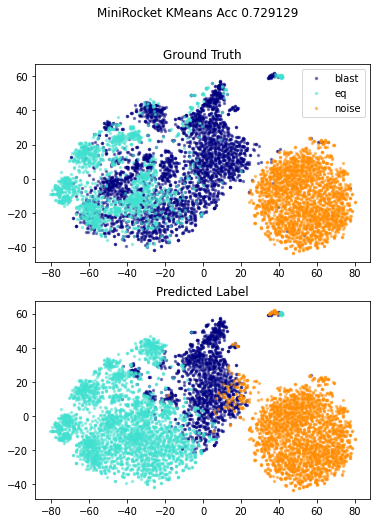

In [17]:
plotter(feature_2d, aligned_pred, y_test, target_names, train_valid_acc, 'MiniRocket KMeans', None, vis=True, anchors=None)

# MiniRocket + logistic regression/classifier

In [18]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat.reshape(X_feat.shape[0], X_feat.shape[1], 1), y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)

model = build_ts_model(MiniRocketHead, dls=dls)
learn = Learner(dls, model, metrics=accuracy)
epoch = 30
timer.start()
learn.fit_one_cycle(epoch, 3e-4)    # epoch 30 (20 ~ 100),  learning rate 3e-4
timer.stop()


epoch,train_loss,valid_loss,accuracy,time
0,0.356401,0.291702,0.897602,00:01
1,0.217724,0.177558,0.945561,00:01
2,0.163086,0.134911,0.951393,00:01
3,0.147709,0.118620,0.959819,00:01
4,0.120789,0.113822,0.957874,00:01
5,0.123003,0.092456,0.963059,00:01
6,0.108500,0.107583,0.963707,00:01
7,0.080984,0.106733,0.955930,00:01
8,0.088288,0.084396,0.970188,00:01
9,0.084406,0.081188,0.967596,00:00


Total time        : 0:00:31.398674


In [19]:
probas, _, cls_pred = learn.get_X_preds(X_test_feat.reshape(X_test_feat.shape[0], X_test_feat.shape[1], 1))
cls_pred = cls_pred.astype(int)
print('Test accuracy', sklearn.metrics.accuracy_score(y_test, cls_pred))

Test accuracy 0.9771627344222625


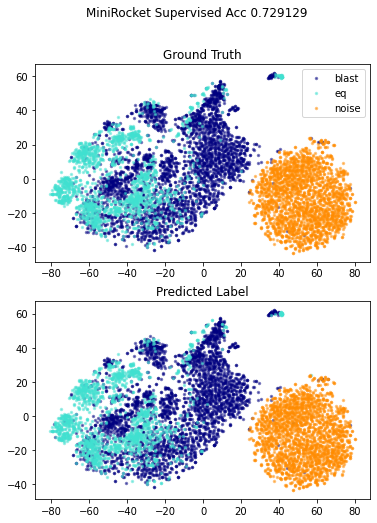

In [20]:
plotter(feature_2d, cls_pred, y_test, target_names, train_valid_acc, 'MiniRocket Supervised', None, vis=True, anchors=None)

# cluster head

In [36]:
from minirocket_cluster_head import SCANLoss, train, test, mine_nearest_neighbors, ClusterHead

In [37]:
mrf84 = MiniRocketFeatures(x_train.shape[1], x_train.shape[2], num_features=84).to(device)
mrf84.fit(x_train)
X_feat_84 = get_minirocket_features(X, mrf84, chunksize=512, to_np=True).reshape(X.shape[0], -1)
id_84 = mine_nearest_neighbors(X_feat_84, top_k=3)


In [38]:
criterion = SCANLoss()

import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

train_i = torch.arange(len(y_train))
train_set = TensorDataset(torch.Tensor(X_feat), torch.Tensor(X_feat[id_84[:, 1]]))  # create your dataset

test_i = torch.arange(len(y_test))
test_set = TensorDataset(torch.Tensor(X_test_feat), torch.Tensor(y_test))

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

model = ClusterHead(feat=X_feat.shape[1])
model.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=1e-4)
sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)
best_acc = 0

In [39]:
start = time.time()
for epoch in range(20):
    train(train_loader, model, optimizer, criterion)
    preds, y_t = test(test_loader, model)
    print('Epoch %d' % epoch)
    c_acc, _ = cluster_acc(np.array(y_t), np.array(preds))
    if c_acc > best_acc:
        best_acc = c_acc
    sched.step()
end = time.time()
print("Best test clustering accuracy %.4f" % best_acc)
print('data shape %s' % str(x_train.shape) + str(x_valid.shape) + str(x_test.shape))
print("total time(feature init + Cluster Head training + evaluate cluster accuracy) takes %d seconds, %s" % (end - start, str(datetime.timedelta(seconds=end-start))))

-987.9095240831375
Epoch 0
[0 1 2] [1 0 2]
[[1233 1383    0]
 [1684  197   13]
 [  50    1 2051]]
precision recall  F1 score in micro: (0.7740471869328494, 0.7740471869328494, 0.7740471869328494, None)
precision recall  F1 score in macro: (0.7978435552587304, 0.8120136785048778, 0.7788470887028635, None)
precision recall  F1 score in weighted: (0.8299725319092248, 0.7740471869328494, 0.7758556842651039, None)
-1003.7807281017303
Epoch 1
[0 1 2] [1 0 2]
[[1067 1277    0]
 [1877  304   22]
 [  23    0 2042]]
precision recall  F1 score in micro: (0.7858439201451906, 0.7858439201451906, 0.7858439201451906, None)
precision recall  F1 score in macro: (0.7952257266931902, 0.8098944226679006, 0.7886380999948736, None)
precision recall  F1 score in weighted: (0.8212758080672001, 0.7858439201451906, 0.7901751378100413, None)
-1004.7640343904495
Epoch 2
[0 1 2] [1 0 2]
[[1033 1224    0]
 [1883  357    0]
 [  51    0 2064]]
precision recall  F1 score in micro: (0.7820629159104658, 0.78206291591046

In [50]:
preds, y_t = test(test_loader, model)
train_valid_acc, chead_pred = cluster_acc(np.array(y_t), np.array(preds))

[0 1 2] [1 0 2]
[[ 966 1201    0]
 [1903  380    6]
 [  98    0 2058]]
precision recall  F1 score in micro: (0.7807017543859649, 0.7807017543859649, 0.7807017543859649, None)
precision recall  F1 score in macro: (0.7800450970711298, 0.7993758083595921, 0.780118464460899, None)
precision recall  F1 score in weighted: (0.8035502993514249, 0.7807017543859649, 0.7826430044924183, None)


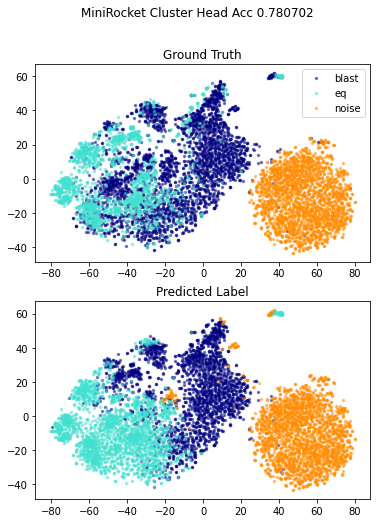

In [51]:
plotter(feature_2d, chead_pred, y_test, target_names, train_valid_acc, 'MiniRocket Cluster Head', None, vis=True, anchors=None)

In [44]:
preds = np.concatenate([aligned_pred.reshape(-1, 1), cls_pred.reshape(-1, 1), chead_pred.reshape(-1, 1)], axis=1)

In [46]:
df_preds = pd.DataFrame(preds, columns = ['Kmeans','Supervised Minirocket Logistic', 'Cluster Head'])
df_preds.to_csv('preds.csv', index=False)